In [1]:
import requests
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely.wkb 
from shapely.ops import cascaded_union
from shapely.geometry import Polygon, Point, MultiPolygon
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

# Protected areas percentage

### Read Global Facets table

In [2]:
path = '/Users/ikersanchez/Vizzuality/PROIEKTUAK/Half-Earth/work/data/'

In [3]:
df = gpd.read_file(path+'global_facets_attr_pressures_all/global_facets_attr_pressures.shp')
df.columns = map(str.lower, df.columns)

### Read Terrestrial and Marine grids

We read the grids from the carto account

In [5]:
account = 'half-earth'
urlCarto = f"https://{account}.carto.com/api/v2/sql"

**Terrestrial grid**

In [6]:
query =("SELECT cartodb_id, cell_id, the_geom FROM terrestrial_grid")

sql = {"q": query}
r = requests.get(urlCarto, params=sql)

data = r.json()

terrestrial = gpd.GeoDataFrame(data.get("rows"))
# Change geometry from WKB to WKT format
terrestrial['geometry'] = terrestrial.apply(lambda x: shapely.wkb.loads(x['the_geom'],hex=True), axis=1 )
terrestrial.drop(columns='the_geom', inplace=True)
terrestrial.sort_values(by=['cartodb_id'], inplace=True)

**Marine grid**

In [7]:
query =("SELECT cartodb_id, cell_id, the_geom FROM marine_grid")

sql = {"q": query}
r = requests.get(urlCarto, params=sql)

data = r.json()

marine = gpd.GeoDataFrame(data.get("rows"))
# Change geometry from WKB to WKT format
marine['geometry'] = marine.apply(lambda x: shapely.wkb.loads(x['the_geom'],hex=True), axis=1 )
marine.drop(columns='the_geom', inplace=True)
marine.sort_values(by=['cartodb_id'], inplace=True)

### Read Protected Areas

In [8]:
all_wdpa = gpd.read_file(path+'wdpa_protected_areas/wdpa_protected_areas.shp')

**Strict**

In [10]:
strict = all_wdpa[(all_wdpa['iucn_cat'] == 'Ia') | 
                         (all_wdpa['iucn_cat'] == 'Ib') |
                         (all_wdpa['iucn_cat'] == 'II') |
                         (all_wdpa['iucn_cat'] == 'III')
                        ][['cartodb_id', 'geometry']]

**Biosphere**

In [11]:
biosphere = all_wdpa[all_wdpa['desig_eng'].str.contains('Biosphere', regex=False)][['cartodb_id', 'geometry']]

**Other**

In [13]:
other = all_wdpa[(all_wdpa['iucn_cat'] != 'Ia') & 
                         (all_wdpa['iucn_cat'] != 'Ib') &
                         (all_wdpa['iucn_cat'] != 'II') &
                         (all_wdpa['iucn_cat'] != 'III') &
                         (~all_wdpa['desig_eng'].str.contains('Aborig', regex=False)) &
                         (~all_wdpa['desig_eng'].str.contains('Indigen', regex=False)) &
                         (~all_wdpa['desig_eng'].str.contains('Commun', regex=False)) &
                         (~all_wdpa['desig_eng'].str.contains('Conservanc', regex=False)) &
                         (~all_wdpa['desig_eng'].str.contains('Local', regex=False)) &
                         (~all_wdpa['desig_eng'].str.contains('Region', regex=False)) &
                         (~all_wdpa['desig_eng'].str.contains('Trust', regex=False)) &
                         (~all_wdpa['desig_eng'].str.contains('Conservator', regex=False)) &
                         (~all_wdpa['desig_eng'].str.contains('Private', regex=False)) &
                         (~all_wdpa['desig_eng'].str.contains('Nature Center', regex=False)) 
                        ][['cartodb_id', 'geometry']]

**Conservation**

In [14]:
conservation = gpd.read_file(path+'community_conservation_areas/community_conservation_areas.shp')

### Percentege of protected areas inside each cell

We use geopandas’s R-tree spatial index to find which protected area lie within each grid cells

In [16]:
def rtree_intersect(gdf, grid):
    percentage = []
    sindex = gdf.sindex
    # we iterate over the cells
    for n, cell in enumerate(tqdm(grid.geometry)):
        # protected areas that intersect with the cell
        possible_matches_index = list(sindex.intersection(cell.bounds))
        possible_matches = gdf.iloc[possible_matches_index]
        # intersection between the protected areas and the cell
        precise_matches = possible_matches.intersection(cell)
        # percentage of the cell covered by protected areas
        percentage.append(cascaded_union(precise_matches).area/cell.area*100) 
    return percentage

In [54]:
# DataFrames to save the outputs
marine_per = marine[['cell_id', 'geometry']]
terrestrial_per = terrestrial[['cell_id', 'geometry']]

# Dictionaries with the different grids and protected areas
grids = {"terrestrial":terrestrial, "marine":marine}
areas = {"strict":strict, "biosphere":biosphere, "conservation":conservation, "other":other, "all_wdpa":all_wdpa}

for grid_key in grids.keys():
    for area_key in areas.keys():
        print(f"For {grid_key}, {area_key}")
        percentage = rtree_intersect(areas[area_key], grids[grid_key])
        if grid_key is "terrestrial":
            terrestrial_per[area_key] = percentage
            terrestrial_per[area_key] = terrestrial_per[area_key].map('{:3.1f}'.format).apply(pd.to_numeric)
        else:
            marine_per[area_key] = percentage
            marine_per[area_key] = marine_per[area_key].map('{:3.1f}'.format).apply(pd.to_numeric)

  0%|          | 0/12670 [00:00<?, ?it/s]

For terrestrial, strict


  0%|          | 0/12670 [00:00<?, ?it/s]

For terrestrial, biosphere


100%|██████████| 12670/12670 [00:16<00:00, 779.65it/s]


For terrestrial, conservation


  0%|          | 2/12670 [00:00<19:22, 10.89it/s]

For terrestrial, other


  0%|          | 0/179484 [00:00<?, ?it/s]

For marine, strict


  0%|          | 311/179484 [00:00<01:59, 1493.75it/s]

For marine, biosphere


  0%|          | 17/179484 [00:00<19:06, 156.56it/s]

For marine, conservation


  0%|          | 0/179484 [00:00<?, ?it/s]

For marine, other


100%|██████████| 179484/179484 [43:06<00:00, 15.88it/s]


**Example of an
individual cells**

In [62]:
def rtree_intersect_cell(gdf, cell):
    sindex = gdf.sindex
    # protected areas that intersect with the cell
    possible_matches_index = list(sindex.intersection(cell.bounds))
    possible_matches = gdf.iloc[possible_matches_index]
    # intersection between the protected areas and the cell
    precise_matches = possible_matches.intersection(cell)
    # percentage of the cell covered by protected areas
    percentage.append(cascaded_union(precise_matches).area/cell.area*100) 
    return percentage

In [82]:
grids = {"terrestrial":terrestrial, "marine":marine}
areas = {"strict":strict, "biosphere":biosphere, "conservation":conservation, "other":other}

grid = grids['terrestrial']
gdf = areas['other']

cell = terrestrial[terrestrial['cell_id'] == '9811'].geometry.iloc[0]

In [83]:
sindex = gdf.sindex
# protected areas that intersect with the cell
possible_matches_index = list(sindex.intersection(cell.bounds))
possible_matches = gdf.iloc[possible_matches_index]
# intersection between the protected areas and the cell
precise_matches = possible_matches.intersection(cell)
# percentage of the cell covered by protected areas
cascaded_union(precise_matches).area/cell.area*100

6.084124205692463

(29.965066214788994, 31.328396867816803)

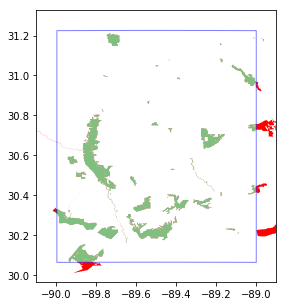

In [87]:
fig, ax = plt.subplots(figsize=[5,5])
ax.set_aspect('equal')

possible_matches.plot(ax=ax,color='r')
precise_matches.plot(ax=ax,color='g')
gpd.GeoDataFrame({'geometry':cell}).plot(ax=ax,color='w', edgecolor='b', alpha=0.5)

plt.xlim(cell.bounds[0]-0.1,cell.bounds[2]+0.1)
plt.ylim(cell.bounds[1]-0.1,cell.bounds[3]+0.1)

**Add percentage columns to table**

In [ ]:
terrestrial_per.drop(columns=['geometry'], inplace= True)
marine_per.drop(columns=['geometry'], inplace= True)
per = pd.concat([terrestrial_per,marine_per])
df_new = pd.merge(df, per, how='left', on=['cell_id'])

**Save new table**

In [25]:
df_new.to_file(path+'global_facets_attr_pressures_vizz/global_facets_attr_pressures_vizz.shp')

**Add the columns of interest to a new table in carto**

```sql

WITH b as (SELECT cell_id, strict, conservati, biosphere, other, rank_sr, rank_rsr, rank_total, location, taxa, feature_da FROM global_facets_attr_pressures_vizz_old)

SELECT row_number() over() as cartodb_id, a.the_geom, a.the_geom_webmercator,
a.taxa, a.focal_spp, a.cell_id_nu, a.prop_land, a.isisland, a.agricultur, a.urban, a.rainfed, a.sr, a.ave_rsr, a.sum_rsr, a.ave_rsr_pc, a.sum_rsr_pc, a.sr_pc, a.cell_id,
b.strict, b.conservati, b.biosphere, b.other, b.rank_sr, b.rank_rsr, b.rank_total, b.location, b.feature_da FROM global_facets_20181004 as a
INNER JOIN b ON a.cell_id = b.cell_id AND a.taxa = b.taxa


```